Task:
1.  quantization to INT8:
    1. Perform training 
    2. recompute the loss using the quantized model
    3. ultimately reproduce Fig 9 from the paper, adding additional an int8-quantized MLPF model (e.g. dashed orange line)
    
2. Again perform Quantizatio on Fp16:

    1. Perform training
    2. Recompute the loss

3. Check the physics loss in all of these three plots.


In [1]:
import torch
torch.set_num_threads(1)
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

In [2]:
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

#Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [3]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

In [24]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

class QuantizeFeaturesStub(torch.nn.Module):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
def mlpf_loss(y, ypred):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    npart = y["pt"].numel()

    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = 100 * loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = 10 * torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all particles
    loss["Classification"] = loss_classification.sum() / npart
    loss["Regression"] = loss_regression.sum() / npart

    loss["Total"] = loss["Classification"] + loss["Regression"]
    return loss
    
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ReLU()
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act, nn.Linear(width, embedding_dim), self.act
        )

        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
#         mask = mask.to(x.dtype)        
#         x = x * mask.unsqueeze(-1).expand(-1, -1, x.size(2))

        
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ReLU  # Change activation function here
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum


model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [18]:
torch.set_grad_enabled(True)  # Context-manager 


In [25]:
max_events_train = 1000
events_per_batch = 10

losses = []

#Training loop
inds_train = range(0,max_events_train,events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind,ind+events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0]!=0

    preds = model(X_features_padded, mask)
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    loss["Total"].backward()
    optimizer.step()
    current_loss = loss["Total"].detach().item()
    losses.append(current_loss)
    print("Loss={:.2f}".format(loss["Total"].detach().item()))

Loss=137.01
Loss=114.08
Loss=84.22
Loss=95.92
Loss=76.37
Loss=82.41
Loss=94.59
Loss=82.00
Loss=72.23
Loss=78.86
Loss=86.80
Loss=87.57
Loss=81.10
Loss=95.48
Loss=79.73
Loss=76.10
Loss=70.63
Loss=64.91
Loss=74.31
Loss=81.62
Loss=52.31
Loss=66.57
Loss=57.34
Loss=67.54
Loss=73.51
Loss=70.03
Loss=58.75
Loss=65.10
Loss=58.10
Loss=68.45
Loss=64.76
Loss=48.87
Loss=59.88
Loss=53.66
Loss=57.42
Loss=53.73
Loss=50.85
Loss=59.97
Loss=55.42
Loss=45.55
Loss=60.15
Loss=51.68
Loss=50.70
Loss=43.16
Loss=52.30
Loss=49.57
Loss=52.24
Loss=56.40
Loss=51.59
Loss=48.62
Loss=51.22
Loss=46.94
Loss=34.47
Loss=44.94
Loss=45.97
Loss=44.79
Loss=34.96
Loss=39.49
Loss=46.12
Loss=40.00
Loss=49.94
Loss=44.07
Loss=43.71
Loss=43.85
Loss=45.03
Loss=40.58
Loss=47.92
Loss=42.67
Loss=55.16
Loss=39.17
Loss=45.27
Loss=40.33
Loss=45.58
Loss=40.39
Loss=42.10
Loss=44.69
Loss=39.20
Loss=36.05
Loss=36.05
Loss=34.46
Loss=36.35
Loss=34.88
Loss=35.32
Loss=37.58
Loss=37.03
Loss=37.71
Loss=35.87
Loss=34.22
Loss=36.36
Loss=37.62
Loss=38.

In [ ]:
# print(mask.shape)

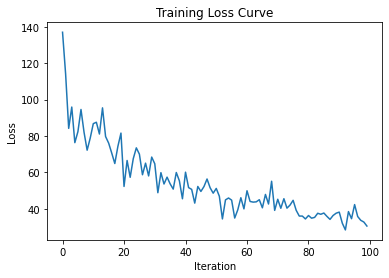

In [26]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [13]:
# losses

## Quantized model

In [27]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
model_prepared = torch.ao.quantization.prepare(model)

#calibrate on data
num_events_to_calibrate = 1
for ind in range(1000,1000+num_events_to_calibrate):
    X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    mask = X[:, :, 0]!=0
    model_prepared(X, mask)

model_int8 = torch.ao.quantization.convert(model_prepared)

## Training on the quantized model

In [22]:
# model_int8

Loss=126.94
Loss=126.72
Loss=125.65
Loss=128.24
Loss=126.23
Loss=126.90
Loss=128.32
Loss=127.96
Loss=127.07
Loss=126.83
Loss=128.59
Loss=127.08
Loss=127.75
Loss=128.63
Loss=127.08
Loss=126.89
Loss=129.08
Loss=124.94
Loss=128.12
Loss=129.43
Loss=125.32
Loss=126.06
Loss=126.15
Loss=127.40
Loss=126.85
Loss=127.25
Loss=126.99
Loss=126.62
Loss=126.59
Loss=129.06
Loss=127.17
Loss=126.58
Loss=127.10
Loss=126.60
Loss=126.44
Loss=126.12
Loss=126.81
Loss=127.11
Loss=126.28
Loss=126.41
Loss=129.41
Loss=128.08
Loss=126.48
Loss=125.70
Loss=127.35
Loss=125.92
Loss=127.92
Loss=128.06
Loss=126.85
Loss=127.40
Loss=127.15
Loss=126.06
Loss=125.19
Loss=126.11
Loss=127.35
Loss=125.94
Loss=125.12
Loss=125.96
Loss=127.96
Loss=125.91
Loss=128.42
Loss=126.23
Loss=127.36
Loss=128.03
Loss=127.64
Loss=125.96
Loss=128.22
Loss=125.82
Loss=132.69
Loss=126.09
Loss=127.09
Loss=127.74
Loss=128.89
Loss=128.24
Loss=128.48
Loss=127.83
Loss=126.87
Loss=126.34
Loss=126.98
Loss=127.09
Loss=126.10
Loss=126.98
Loss=126.78
Loss

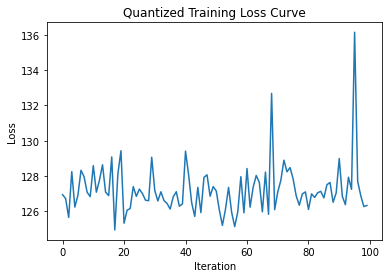

In [30]:
max_events_train = 1000
events_per_batch = 10
quantized_losses = []

# Training loop
inds_train = range(0, max_events_train, events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0] != 0

    preds = model_int8(X_features_padded, mask)
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)

    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    
    # Ensure all tensors contributing to the loss have requires_grad = True
    for key, value in loss.items():
        if value.requires_grad is False:
            value.requires_grad = True

    # Convert the loss tensor 
    loss_total = loss["Total"].sum()  
#     loss_total.backward()
    optimizer.step()

    current_loss = loss_total.detach().item()
    quantized_losses.append(current_loss)
    print("Loss={:.2f}".format(current_loss))

# Plot
plt.plot(quantized_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Quantized Training Loss Curve')
plt.show()


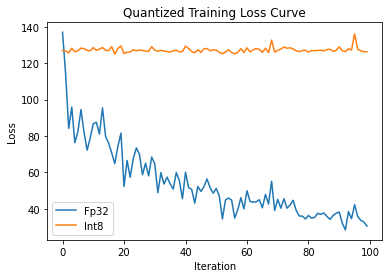

In [31]:
plt.plot(losses, label='Fp32')
plt.plot(quantized_losses, label='Int8')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Quantized Training Loss Curve')
plt.show()


## FP16 Quantization

In [33]:
model_fp16 = model.to(torch.float16)

In [34]:
model_fp16

MLPF(
  (nn0_id): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
  (nn0_reg): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv_id): ModuleList(
    (0-1): 2 x SelfAttentionLayer(
      (act): ReLU()
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (seq): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
       

In [35]:
model_fp16 = model.to(torch.float16)
model_quantized_fp16 = torch.quantization.quantize_dynamic(
    model_fp16, {torch.nn.Linear}, dtype=torch.float16
)


/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [36]:
model_quantized_fp16

MLPF(
  (nn0_id): Sequential(
    (0): DynamicQuantizedLinear(in_features=17, out_features=256, dtype=torch.float16)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): DynamicQuantizedLinear(in_features=256, out_features=256, dtype=torch.float16)
  )
  (nn0_reg): Sequential(
    (0): DynamicQuantizedLinear(in_features=17, out_features=256, dtype=torch.float16)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): DynamicQuantizedLinear(in_features=256, out_features=256, dtype=torch.float16)
  )
  (conv_id): ModuleList(
    (0-1): 2 x SelfAttentionLayer(
      (act): ReLU()
      (mha): MultiheadAttention(
        (out_proj): DynamicQuantizedLinear(in_features=256, out_features=256, dtype=torch.qint8, qscheme=torch.per_channel_affine)
      )
      (norm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm1): LayerNorm((256,

In [44]:
max_events_train = 1000
events_per_batch = 10
quantized_losses_fp16 = []

# Training loop
inds_train = range(0, max_events_train, events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]  # Ensure X_features are float32
    X_features_padded = pad_sequence(X_features, batch_first=True).to(torch.float32)  # Convert to float32
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]  # Ensure y_targets are float32
    y_targets_padded = pad_sequence(y_targets, batch_first=True).to(torch.float32)  # Convert to float32
    
    mask = X_features_padded[:, :, 0] != 0
    
    # Convert model to float32
    model_quantized_fp16_float32 = model_quantized_fp16.to(torch.float32)
    
    # Move tensors to the same device as the model parameters
    device = next(model_quantized_fp16_float32.parameters()).device
    X_features_padded = X_features_padded.to(device)
    mask = mask.to(device)
    
    preds = model_quantized_fp16_float32(X_features_padded, mask)  # Ensure input to model is float32
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    
    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    
    # Ensure all tensors contributing to the loss have requires_grad = True
    for key, value in loss.items():
        if not value.requires_grad:
            value.requires_grad = True
    
    # Convert the loss tensor 
    loss_total = loss["Total"].sum()  
    loss_total.backward()
    optimizer.step()
    
    current_loss = loss_total.detach().item()
    quantized_losses_fp16.append(current_loss)
    print("Loss={:.2f}".format(current_loss))

# Plot
plt.plot(quantized_losses_fp16)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('FP16 Quantized Training Loss Curve')
plt.show()


AttributeError: 'function' object has no attribute 'device'

---
---
---

In [ ]:
max_events_train = 1000
events_per_batch = 10
quantized_losses = []

# Training loop
inds_train = range(0, max_events_train, events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0] != 0

    preds = model_int8(X_features_padded, mask)
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)

    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    
    # Ensure all tensors contributing to the loss have requires_grad = True
    for key, value in loss.items():
        if value.requires_grad is False:
            value.requires_grad = True

    # Convert the loss tensor to a scalar before calling backward
    loss_total = loss["Total"].sum()  
    loss_total.backward()
    optimizer.step()

    current_loss = loss_total.detach().item()
    losses.append(current_loss)
    print("Loss={:.2f}".format(current_loss))


plt.plot(quantized_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Quantized Training Loss Curve')
plt.show()

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    losses_quantized = []

    for ind in inds_train:
        optimizer.zero_grad()
        ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
        X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
        X_features_padded = pad_sequence(X_features, batch_first=True)
        y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
        y_targets_padded = pad_sequence(y_targets, batch_first=True)

        mask = X_features_padded[:, :, 0] != 0

        preds = model_int8(X_features_padded, mask)  # Use quantized model here
        preds_unpacked = unpack_predictions(preds)
        targets_unpacked = unpack_target(y_targets_padded)
        loss = mlpf_loss(targets_unpacked, preds_unpacked)
        
        # Ensure all tensors contributing to the loss have requires_grad = True
        for key, value in loss.items():
            if value.requires_grad is False:
                value.requires_grad = True
        
        loss["Total"].backward()
        optimizer.step()
        current_loss = loss["Total"].detach().item()
        losses_quantized.append(current_loss)
        print("Iteration: {}, Loss: {:.2f}".format(ind, loss["Total"].detach().item()))

    # Plot training loss
    plt.plot(losses_quantized)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve (Quantized Model) - Epoch {}'.format(epoch + 1))
    plt.show()


In [ ]:
# Plotting both losses on the same plot
plt.plot(losses, label='Original Model')
plt.plot(quantized_losses, label='Quantized Model')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()